In [1]:
import numpy as np 
import pandas as pd 
import plotly.io as pio
pio.renderers.default='browser'
import torch
from itertools import combinations
import math
from dk_model import DeepKrigingTrainer
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.colors import ListedColormap



In [2]:
deposit_data = pd.read_csv("Data/final_dataset_1_no_0.csv", low_memory=False)


# Deepkriging train test split

In [3]:
covariates = ['CP_Total','PO_Total','PY_Total','RQD_Pct','Cr_ppm'] 
phi_columns = deposit_data.columns[10:].tolist()
#phi_columns = ['X','Y','Z']
deposit_data = deposit_data.dropna(subset=['Density_gcm3'] + covariates + phi_columns)

p = len(phi_columns) + len(covariates)

trainer_regular = DeepKrigingTrainer(deposit_data, covariates, regular_nn=False, plot_errors=False)
#trainer_regular = DeepKrigingTrainer(deposit_data, covariates, regular_nn=True, plot_errors=False)

trainer_regular.train_neural_network(mode="regular", test_size=0.2)
test_predictions = trainer_regular.test_predictions

x_test = trainer_regular.x_test_df

Deposit Data MSE: 0.0017, MAE: 0.0265, R2: 0.8866


In [4]:
def select_columns(x_test, columns):
    if isinstance(columns, list):
        selected_columns = [col for col in x_test.columns if col not in columns]
    elif isinstance(columns, str):
        # Handle the case where columns is a single column name
        selected_columns = [col for col in x_test.columns if col != columns]
    else:
        raise ValueError("Invalid input for columns")
    return selected_columns

def filter(column):
    if isinstance(column, list):
        X_column = x_test[column]
    elif isinstance(column, str):
        # Handle the case where column is a single column name
        X_column = x_test[[column]]
    else:
        raise ValueError("Invalid input for column")
    return X_column

In [5]:
# torch.manual_seed(42)
# np.random.seed(42)

# # Create all possible combinations of columns and generate a new DataFrame for each combination
# def subgroups2(column):
#     X_column = filter(column)
#     selected_columns = select_columns(x_test, column)
#     X_column_c = x_test[selected_columns]
#     covariates = ['CP_Total', 'PO_Total', 'PY_Total', 'RQD_Pct', 'Cr_ppm']
#     covariates_minus_j = covariates.copy()
#     covariates_minus_j.append(phi_columns)
#     covariates_minus_j.remove(column)

#     new_dataframes_column = []
#     omega = 0
# # The first loop goes over the number of selected columns
# # The second loop goes over all the combinations of the selected columns 
#     for r in range(0, len(covariates_minus_j) + 1):
#         power_set = combinations(covariates_minus_j, r)
#         for combo in power_set:
#             new_df = X_column_c.copy() 
#             new_df[list(combo)] = 0
#             S = pd.concat([new_df, X_column], axis=1)
#             sorted_columns = x_test.columns.intersection(S.columns)
#             S = S[sorted_columns]
#             S_copy = S.copy()
#             S_copy[column] = 0
#             new_dataframes_column.append(S)
#             new_dataframes_column.append(S_copy)

#             deposit_data_c = deposit_data.copy()
#             deposit_data_c[list(combo)] =0
#             deposit_data_c_j = deposit_data_c.copy()
#             deposit_data_c_j[column] = 0

#             trainer_regular = DeepKrigingTrainer(deposit_data_c, covariates, regular_nn=False, plot_errors=False)
#             trainer_regular.train_neural_network(mode="regular", test_size=0.2)
#             pred_S = trainer_regular.model2(torch.tensor(S.values, dtype=torch.float32)).detach().numpy().flatten()

#             trainer_regular = DeepKrigingTrainer(deposit_data_c_j, covariates, regular_nn=False, plot_errors=False)
#             trainer_regular.train_neural_network(mode="regular", test_size=0.2)
#             pred_S_j = trainer_regular.model2(torch.tensor(S_copy.values, dtype=torch.float32)).detach().numpy().flatten()

#             delta_j = pred_S - pred_S_j
#             size_G = len(covariates) + 1
#             G_fact = math.factorial(size_G)
#             size_S = size_G - len(combo) - 1  
#             weight = math.factorial(size_S)*math.factorial(size_G - size_S - 1)*(1/G_fact)
#             omega += weight*delta_j # sum extends over all subsets of the power set of covariates_minus_j (both for loops are needed)

#     return new_dataframes_column, omega

In [6]:
import time
from itertools import combinations
from tqdm import tqdm

torch.manual_seed(42)
np.random.seed(42)

# Create all possible combinations of columns and generate a new DataFrame for each combination
def subgroups2(column):
    start_time = time.time()  # Start time tracking
    X_column = filter(column)
    selected_columns = select_columns(x_test, column)
    X_column_c = x_test[selected_columns]
    covariates = ['CP_Total', 'PO_Total', 'PY_Total', 'RQD_Pct', 'Cr_ppm']
    covariates_minus_j = covariates.copy()
    covariates_minus_j.append(phi_columns)
    covariates_minus_j.remove(column)

    new_dataframes_column = []
    omega = 0

    # The first loop goes over the number of selected columns
    # Wrapping the outer loop with tqdm to monitor progress
    for r in tqdm(range(0, len(covariates_minus_j) + 1), desc="Outer Loop Progress"):
        power_set = combinations(covariates_minus_j, r)

        # Wrapping the inner loop with tqdm for finer-grained tracking
        for combo in tqdm(power_set, desc=f"Combinations of size {r}", leave=False):
            new_df = X_column_c.copy() 
            new_df[list(combo)] = 0
            S = pd.concat([new_df, X_column], axis=1)
            sorted_columns = x_test.columns.intersection(S.columns)
            S = S[sorted_columns]
            S_copy = S.copy()
            S_copy[column] = 0
            new_dataframes_column.append(S)
            new_dataframes_column.append(S_copy)

            deposit_data_c = deposit_data.copy()
            deposit_data_c[list(combo)] = 0
            deposit_data_c_j = deposit_data_c.copy()
            deposit_data_c_j[column] = 0

            trainer_regular = DeepKrigingTrainer(deposit_data_c, covariates, regular_nn=False, plot_errors=False)
            trainer_regular.train_neural_network(mode="regular", test_size=0.2)
            pred_S = trainer_regular.model2(torch.tensor(S.values, dtype=torch.float32)).detach().numpy().flatten()

            trainer_regular = DeepKrigingTrainer(deposit_data_c_j, covariates, regular_nn=False, plot_errors=False)
            trainer_regular.train_neural_network(mode="regular", test_size=0.2)
            pred_S_j = trainer_regular.model2(torch.tensor(S_copy.values, dtype=torch.float32)).detach().numpy().flatten()

            delta_j = pred_S - pred_S_j
            size_G = len(covariates) + 1
            G_fact = math.factorial(size_G)
            size_S = size_G - len(combo) - 1  
            weight = math.factorial(size_S) * math.factorial(size_G - size_S - 1) * (1 / G_fact)
            omega += weight * delta_j  # sum extends over all subsets of the power set

    end_time = time.time()  # End time tracking
    print(f"Execution time: {end_time - start_time:.2f} seconds")

    return new_dataframes_column, omega


In [7]:
# permus_phi, omega_phi = subgroups2(phi_columns)
# #save the results just like the ones in the next cell 
# #pd.concat(permus_phi).to_csv('permutations2_phi_2.csv')
# omega_col = omega_phi
# omega_df = pd.DataFrame(omega_col, columns=['omega'])
# omega_df.to_csv('omega_phi_2.csv')

# X_phi_c = x_test.iloc[:, len(phi_columns):]
# X_easy = X_phi_c
# X_phi = x_test.iloc[:, :len(phi_columns)]
# for col in X_easy.columns.tolist():
#     exec(f"permutations2_{col}, omega_{col} = subgroups2('{col}')")
#     # Save omega variables as CSV
#     omega_col = eval(f'omega_{col}')
#     omega_df = pd.DataFrame(omega_col, columns=['omega'])
#     omega_df.to_csv(f'omega_{col}_2.csv')

In [8]:
omega_phi_df = pd.read_csv('Data/omega_phi.csv')
omega_CP_Total_df = pd.read_csv('Data/omega_CP_Total.csv')
omega_PO_Total_df = pd.read_csv('Data/omega_PO_Total.csv')
omega_PY_Total_df = pd.read_csv('Data/omega_PY_Total.csv')
omega_RQD_df = pd.read_csv("Data/omega_RQD_Pct.csv")
omega_Cr_Total_df = pd.read_csv("Data/omega_Cr_ppm.csv")

omega_phi = omega_phi_df['omega'].to_numpy()
omega_CP_Total = omega_CP_Total_df['omega'].to_numpy()
omega_PO_Total = omega_PO_Total_df['omega'].to_numpy()
omega_PY_Total = omega_PY_Total_df['omega'].to_numpy()
omega_RQD_Pct = omega_RQD_df['omega'].to_numpy()
omega_Cr_ppm = omega_Cr_Total_df['omega'].to_numpy()

In [9]:
filtered_unnormalised_deposit_data = pd.read_csv('Data/filtered_unnormalised_deposit_data.csv')

# Calculate the multiplier for each column
multipliers = {}
for column in covariates + ['Density_gcm3'] + ['X'] + ['Y'] + ['Z']:
    ratio = deposit_data[column] / filtered_unnormalised_deposit_data[column]
    multiplier = ratio.mean()
    multipliers[column] = 1/multiplier

multipliers_df = pd.DataFrame.from_dict(multipliers, orient='index', columns=['Multiplier'])
print(multipliers_df)


                Multiplier
CP_Total      4.000000e+00
PO_Total      1.500000e+01
PY_Total      5.000000e+00
RQD_Pct       1.000000e+02
Cr_ppm        1.670000e+03
Density_gcm3  7.223402e+00
X             6.329118e+06
Y             1.376767e+07
Z             1.778691e+02


c:\Users\23478671\Anaconda3\envs\geostatistics\lib\site-packages\pandas\core\arrays\categorical.py:556: RuntimeWarning:

invalid value encountered in cast

C:\Users\23478671\AppData\Local\Temp\ipykernel_20152\1761421924.py:48: UserWarning:

FixedFormatter should only be used together with FixedLocator



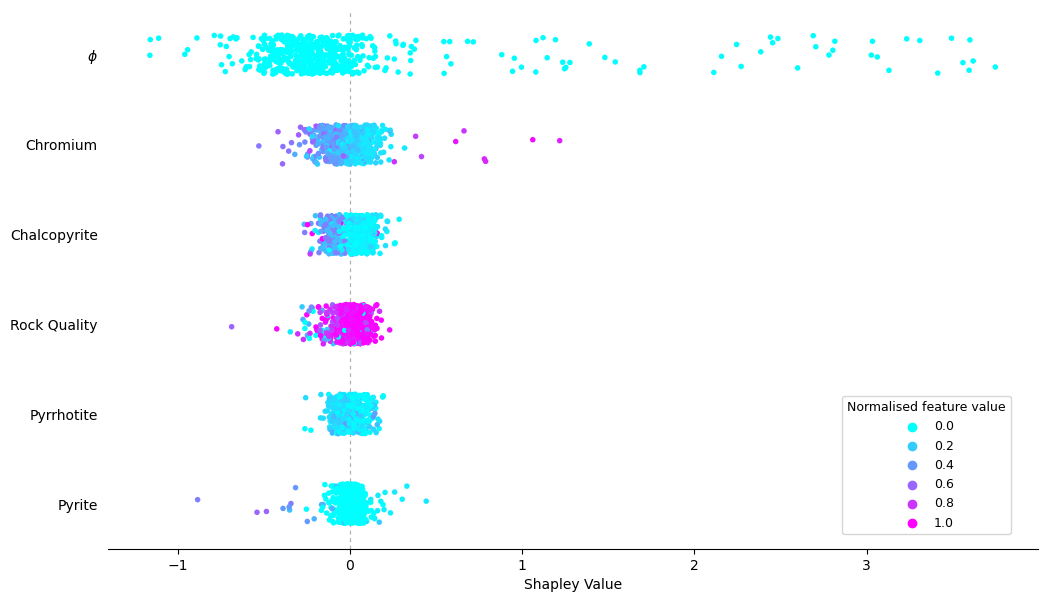

In [10]:
np.random.seed(42)

X_phi_c = x_test.iloc[:, len(phi_columns):]
X_easy = X_phi_c
X_phi = x_test.iloc[:, :len(phi_columns)]

custom_colors = ["#00FFFF", "#FF00FF"]
custom_cmap = LinearSegmentedColormap.from_list('custom_colormap', custom_colors)

df_sv = pd.DataFrame()
features = ['CP_Total', 'PO_Total', 'PY_Total', 'RQD_Pct', 'Cr_ppm']
df_sv['feature'] = sum([[feature] * len(x_test) for feature in features], [])
df_sv['shapley value'] = np.concatenate([omega_CP_Total, omega_PO_Total, omega_PY_Total, omega_RQD_Pct, omega_Cr_ppm])
df_sv['hue'] = np.concatenate([x_test[feature].values for feature in features])

mean_df = pd.DataFrame()
mean_df['Mean'] = X_phi.mean(axis=1)
df_sv_phi = pd.DataFrame()
df_sv_phi["feature"] = ["phi"] * len(x_test)
df_sv_phi["shapley value"] = omega_phi
df_sv_phi['hue'] = mean_df['Mean'].values

df_sv = pd.concat([df_sv, df_sv_phi])

# Calculate the absolute sum of Shapley values for each feature
abs_sum_shapley = df_sv.groupby('feature')['shapley value'].apply(lambda x: np.sum(np.abs(x)))
feature_order = abs_sum_shapley.sort_values(ascending=False).index

# Sort the DataFrame based on the feature order
df_sv['feature'] = pd.Categorical(df_sv['feature'], categories=feature_order, ordered=True)
df_sv = df_sv.sort_values('feature')

# Beeswarm plot with custom colors
fig, ax = plt.subplots(figsize=(12, 7))
ax.axvline(0, c="grey", alpha=0.6, linewidth=0.9, linestyle='--', dashes=(3, 3))
sns.stripplot(
    x=df_sv['shapley value']* multipliers['Density_gcm3'],
    y=df_sv['feature'],
    hue=df_sv['hue'],
    palette=custom_cmap,
    size=4,
    linewidth=0,  
    jitter=0.22 
)
ax.spines.left.set_visible(False)
ax.set_ylabel("")

ax.set_yticklabels([r'$\phi$', 'Chromium','Chalcopyrite', 'Rock Quality',  'Pyrrhotite', 'Pyrite'])



ax.tick_params(axis='x', labelsize=10)  
ax.tick_params(axis='y', labelsize=10)  
ax.set_xlabel("Shapley Value", fontsize=10)


legend = plt.legend(title='Normalised feature value', loc='upper right', bbox_to_anchor=(0.978, 0.295), borderaxespad=0.5, fontsize='9')
legend.get_title().set_fontsize('9') 
ax.spines.right.set_visible(False) 
ax.spines.top.set_visible(False)  
ax.tick_params(left=False, bottom=True)

plt.show()

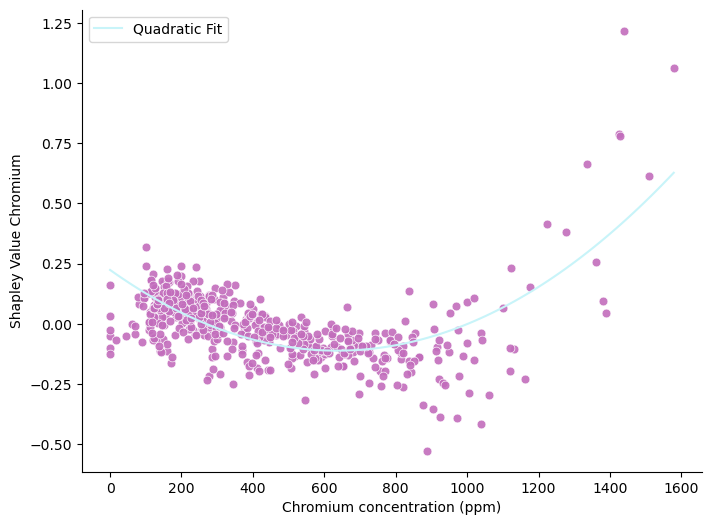

In [11]:
coefficients = np.polyfit(x_test['Cr_ppm'], omega_Cr_ppm, 2)
quadratic_curve = np.poly1d(coefficients)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=x_test['Cr_ppm']* multipliers['Cr_ppm'], y=omega_Cr_ppm* multipliers['Density_gcm3'], s=40, alpha=0.9, color='#C26DBC')

x_values = np.linspace(min(x_test['Cr_ppm']), max(x_test['Cr_ppm']), 100)
plt.plot(x_values* multipliers['Cr_ppm'], quadratic_curve(x_values)* multipliers['Density_gcm3'], color='#C8F4F9', linestyle='-', label='Quadratic Fit')

plt.xlabel('Chromium concentration (ppm)', fontsize=10)
plt.ylabel('Shapley Value Chromium', fontsize=10)


plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.legend()  # Show legend
plt.savefig('Figures/Chromium dependence.png')  
plt.show()


In [12]:
multipliers['Density_gcm3']
instance_idx = 205
#instance_idx = 133
instance_row = x_test.iloc[instance_idx]

df_waterfall_combined = pd.DataFrame()

features = ['CP_Total', 'PO_Total', 'PY_Total', 'RQD_Pct', 'Cr_ppm']

# Calculate the average for columns starting with 'phi_'
phi_columns = [col for col in x_test.columns if col.startswith('phi_')]
phi_value = instance_row[phi_columns].mean()

feature_values = [instance_row[feature] for feature in features] + [phi_value]

# Adjust the decimal places for the phi feature value
df_waterfall_combined['feature'] = [f"{feature}: {value:.2f}" for feature, value in zip(features, feature_values[:-1])] + [f"phi: {phi_value:.4f}"]
df_waterfall_combined['shapley value'] = [
    omega_CP_Total[instance_idx],
    omega_PO_Total[instance_idx],
    omega_PY_Total[instance_idx],
    omega_RQD_Pct[instance_idx],
    omega_Cr_ppm[instance_idx],
    omega_phi[instance_idx]  
]

df_waterfall_combined['shapley value'] = df_waterfall_combined['shapley value']*multipliers['Density_gcm3']

df_waterfall_combined['source'] = ['Shapley'] * len(df_waterfall_combined)

fig_waterfall_combined = go.Figure()

mean_prediction = test_predictions.mean()*multipliers['Density_gcm3']

bar_sums = df_waterfall_combined['shapley value'].cumsum()

for source, color in zip(['Shapley'], ['#00FFFF']):
    source_df = df_waterfall_combined[df_waterfall_combined['source'] == source]
    symbols = ['triangle-right' if val >= 0 else 'triangle-left' for val in source_df['shapley value']]
    fig_waterfall_combined.add_trace(
        go.Waterfall(
            name=f"waterfall_{source}",
            orientation="h",
            y=source_df['feature'],
            x=source_df['shapley value'],
            base=mean_prediction,  # Set the base value
            decreasing=dict(marker=dict(color='#FF00FF')),
            increasing=dict(marker=dict(color='#00FFFF')),
            connector=dict(line=dict(color='rgba(128, 128, 128, 0.5)', width=1, dash='dot')),  # Adjust connector appearance
        )
    )


scaled_pyrrhotite = instance_row["PO_Total"] * multipliers['PO_Total']
scaled_pyrite = instance_row["PY_Total"] * multipliers['PY_Total']
scaled_rock_quality = instance_row["RQD_Pct"] * multipliers['RQD_Pct']
scaled_chromium = instance_row["Cr_ppm"] * multipliers['Cr_ppm']
scaled_chalcopyrite = instance_row["CP_Total"] * multipliers['CP_Total']

ticktext=[
    f'Chalcopyrite: {scaled_chalcopyrite:.2f}',
    f'Pyrrhotite: {scaled_pyrrhotite:.2f}', 
    f'Pyrite: {scaled_pyrite:.2f}', 
    f'Rock Quality: {scaled_rock_quality:.2f}', 
    f'Chromium: {scaled_chromium:.2f}', 
    f'𝝓: {phi_value:.4f}'
]


fig_waterfall_combined.update_layout(
    #title="Waterfall Plot for Shapley Values (Single Instance)",
    width=1000, height=500, font=dict(size=14),
    paper_bgcolor='rgba(0,0,0,0)',  
    plot_bgcolor='rgba(0,0,0,0)',  
    xaxis=dict(
        tickfont=dict(size=12, family='sans-serif', color='black'),
          # Make the x-axis ticks same size and color as y-axis
    ),
    yaxis=dict(
        tickmode='array',
        tickvals=[0, 1, 2, 3, 4, 5],
        ticktext=[
            f'Chalcopyrite (%): {scaled_chalcopyrite:.2f}',
            f'Pyrrhotite (%): {scaled_pyrrhotite:.2f}', 
            f'Pyrite (%): {scaled_pyrite:.2f}', 
            f'Rock Quality (%): {scaled_rock_quality:.2f}', 
            f'Chromium (ppm): {scaled_chromium:.2f}', 
            f'𝝓: {phi_value:.4f}'
        ],
        tickfont=dict(size=12, family='sans-serif', color='black') 
    ),
    annotations=[
        dict(
            x=mean_prediction,
            y=-0.13,
            xref='x',
            yref='paper',
            text=f"E[f(X)] = {mean_prediction:.3f}",
            showarrow=False,
            font=dict(size=12, color='grey'),  
        ),
        dict(
            x= mean_prediction + bar_sums.iloc[-1],  
            y=1.1,
            xref='x',
            yref='paper',
            text=f"f(X) = {(mean_prediction + bar_sums.iloc[-1]):.3f}",
            showarrow=False,
            font=dict(size=12, color='grey'),  
        )
    ]
)

fig_waterfall_combined.update_xaxes(ticks="outside")

fig_waterfall_combined.add_shape(
    type="line",
    x0=3.195,
    y0=0,
    x1=4.605 ,
    y1=0,
    line=dict(color="grey", width=1),
    xref="x",
    yref="paper",
)


fig_waterfall_combined.add_shape(
    type="line",
    x0=mean_prediction + bar_sums.iloc[-1],
    y0=0,
    x1=mean_prediction + bar_sums.iloc[-1],
    y1=1,
    line=dict(color="grey", width=0.5, dash="dot"),
    xref="x",
    yref="paper",
)

fig_waterfall_combined.add_shape(
    type="line",
    x0=mean_prediction + bar_sums.iloc[-1],
    y0=-0.01,
    x1=mean_prediction + bar_sums.iloc[-1],
    y1=0,
    line=dict(color="grey", width=1),
    xref="x",
    yref="paper",
)

fig_waterfall_combined.add_shape(
    type="line",
    x0=mean_prediction,
    y0=-0.01,
    x1=mean_prediction,
    y1=0,
    line=dict(color="grey", width=1),
    xref="x",
    yref="paper",
)

fig_waterfall_combined.update_xaxes(title="Density (g/cm³)", ticks="outside", title_font=dict(size=12, family='sans-serif', color='black'))
fig_waterfall_combined.write_html("Figures/waterfall.html")

print(
    f"Mean prediction: {test_predictions.mean()*multipliers['Density_gcm3']}",
    f"This prediction {test_predictions[instance_idx]*multipliers['Density_gcm3']}",
    f"Theoretical Shapley: {test_predictions[instance_idx]*multipliers['Density_gcm3'] - test_predictions.mean()*multipliers['Density_gcm3']}",
    f"Shapley sum: {df_waterfall_combined['shapley value'].sum()}",
    f"Shapley sum - theoretical Shapley sum: {test_predictions[instance_idx]*multipliers['Density_gcm3'] - test_predictions.mean()*multipliers['Density_gcm3'] - df_waterfall_combined['shapley value'].sum()}",
    sep='\n'  
)


Mean prediction: 3.2168651530485755
This prediction 2.752548294716095
Theoretical Shapley: -0.4643168583324804
Shapley sum: -0.7939987697519013
Shapley sum - theoretical Shapley sum: 0.32968191141942094


In [13]:
density_data = pd.read_csv('Data/cluster_0_data.csv')

mineral = 'Density_gcm3'
filter = ['Sulph1_Code', 'Sulph1_Pct', 'Sulph2_Code', 'Sulph2_Pct']
composite_data = density_data

composite_data = composite_data.dropna(subset=[mineral] + filter)
df1 = composite_data
variable = mineral

C:\Users\23478671\AppData\Local\Temp\ipykernel_20152\4054478244.py:1: DtypeWarning:

Columns (8,9,10,11,12,13,15,21,27,34,35,37,38,40,41,43,44,45,94,96,97,99,100,102,104,106,107,109) have mixed types. Specify dtype option on import or set low_memory=False.



In [14]:
two_composite_1covariates = composite_data

missing_percentage = (two_composite_1covariates.isnull().sum() / len(two_composite_1covariates)) * 100

variables_to_remove = missing_percentage[missing_percentage > 5].index

two_composite_1covariates = two_composite_1covariates.drop(columns=variables_to_remove)


encoded_data = two_composite_1covariates.copy()

threshold = 10

for column in two_composite_1covariates.columns:
    if two_composite_1covariates[column].dtype == 'object':
        unique_values = two_composite_1covariates[column].nunique()
        
        if unique_values <= threshold:
            encoded_columns = pd.get_dummies(encoded_data[column], prefix=column)
            encoded_columns = encoded_columns.astype(int)  
            encoded_data = pd.concat([encoded_data, encoded_columns], axis=1)
            encoded_data = encoded_data.drop(columns=[column])




encoded_columns = [col for col in encoded_data.columns if '_Code_' in col]

total_columns = []

for col in encoded_columns:
    prefix, original_column = col.split('_Code_')
    
    total_column = f"{original_column}_Total"
    total_columns.append(total_column)
    
    encoded_data[total_column] = (
        encoded_data[f"{prefix}_Code_{original_column}"] * encoded_data[f"{prefix}_Pct"]
    )

total_columns = []

category_totals = {}

for col in encoded_columns:
    prefix, original_column = col.split('_Code_')
    
    total_column = f"{original_column}_Total"
    if total_column not in total_columns:
        total_columns.append(total_column)
    
    total_values = encoded_data[f"{prefix}_Code_{original_column}"] * encoded_data[f"{prefix}_Pct"]
    
    if total_column in category_totals:
        category_totals[total_column] += total_values
    else:
        category_totals[total_column] = total_values

for total_column, total_values in category_totals.items():
    encoded_data[total_column] = total_values


In [15]:
variable_names = ['Sc_ppm',
 'Al_pct',
 'Y_ppm',
 'V_ppm',
 'Sr_ppm',
 'Ca_pct',
 'P_ppm',
 'Si_pct',
 'Li_ppm',
 'Mg_pct',
 'La_ppm',
 'RQD_Pct',
 'Alt1_Int_wk',
 'Ba_ppm',
 'Sulph1_Code_PO',
 'IP_pct',
 'Sulph2_Code_CP',
 'Sulph2_Code_PO',
 'X',
 'PY_Total',
 'Z',
 'PO_Total',
 'CP_Total',
 'Cr_ppm',
 'B_ppm',
 'Y',
 'Sb_ppm',
 'Weathering',
 'Lith1_Code']

filtered_encoded_data = encoded_data[encoded_data.columns.intersection(variable_names+ ['Density_gcm3', 'Name'])]

composite_data = encoded_data[['Name', 'X', 'Y', 'Z', 'Density_gcm3', 'RQD_Pct', 'Cr_ppm', 'CP_Total',
       'PO_Total', 'PY_Total', 'Lith1_Code']]
total_columns = ['CP_Total','PO_Total', 'PY_Total']


composite_data.describe()
composite_data.fillna(0, inplace=True)
composite_data

C:\Users\23478671\AppData\Local\Temp\ipykernel_20152\2404403680.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Name,X,Y,Z,Density_gcm3,RQD_Pct,Cr_ppm,CP_Total,PO_Total,PY_Total,Lith1_Code
393,KV-NME001,3498922.13,7511747.51,148.80,3.13,88.00,212.6,1.0,1.0,0.0,UPXO
394,KV-NME001,3498922.68,7511747.45,146.88,3.15,88.00,268.0,1.0,1.0,0.0,UPXO
434,KV-NME001,3498945.16,7511745.25,70.14,3.22,99.00,215.0,1.0,1.0,0.0,UPXO
435,KV-NME001,3498945.73,7511745.20,68.22,3.22,99.00,236.0,1.5,2.0,0.0,UPXO
436,KV-NME001,3498946.29,7511745.15,66.30,3.22,99.00,256.0,2.0,3.0,0.0,UPXO
...,...,...,...,...,...,...,...,...,...,...,...
81071,KV365,3499347.52,7510618.17,85.03,3.44,92.35,131.0,0.2,3.0,0.0,MPHB
81072,KV365,3499347.32,7510617.19,83.30,3.43,92.35,125.0,0.2,3.0,0.0,MPHB
81073,KV365,3499347.13,7510616.22,81.56,3.44,85.84,128.0,0.2,3.0,0.0,MPHB
81074,KV365,3499346.93,7510615.24,79.83,3.40,85.84,129.0,0.2,3.0,0.0,MPHB


In [16]:
columns_to_normalize = ['X', 'Y', 'Z']   

min_values = composite_data[columns_to_normalize].min()

for column in columns_to_normalize:
    composite_data[column] = composite_data[column] - min_values[column]

# Calculate the minimum and maximum values from all three variables
min_values = composite_data[columns_to_normalize].min().min()
max_values = composite_data[columns_to_normalize].max().max()

for column in columns_to_normalize:
    composite_data[column] = (composite_data[column] - min_values) / (max_values - min_values)

C:\Users\23478671\AppData\Local\Temp\ipykernel_20152\1890441399.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\23478671\AppData\Local\Temp\ipykernel_20152\1890441399.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



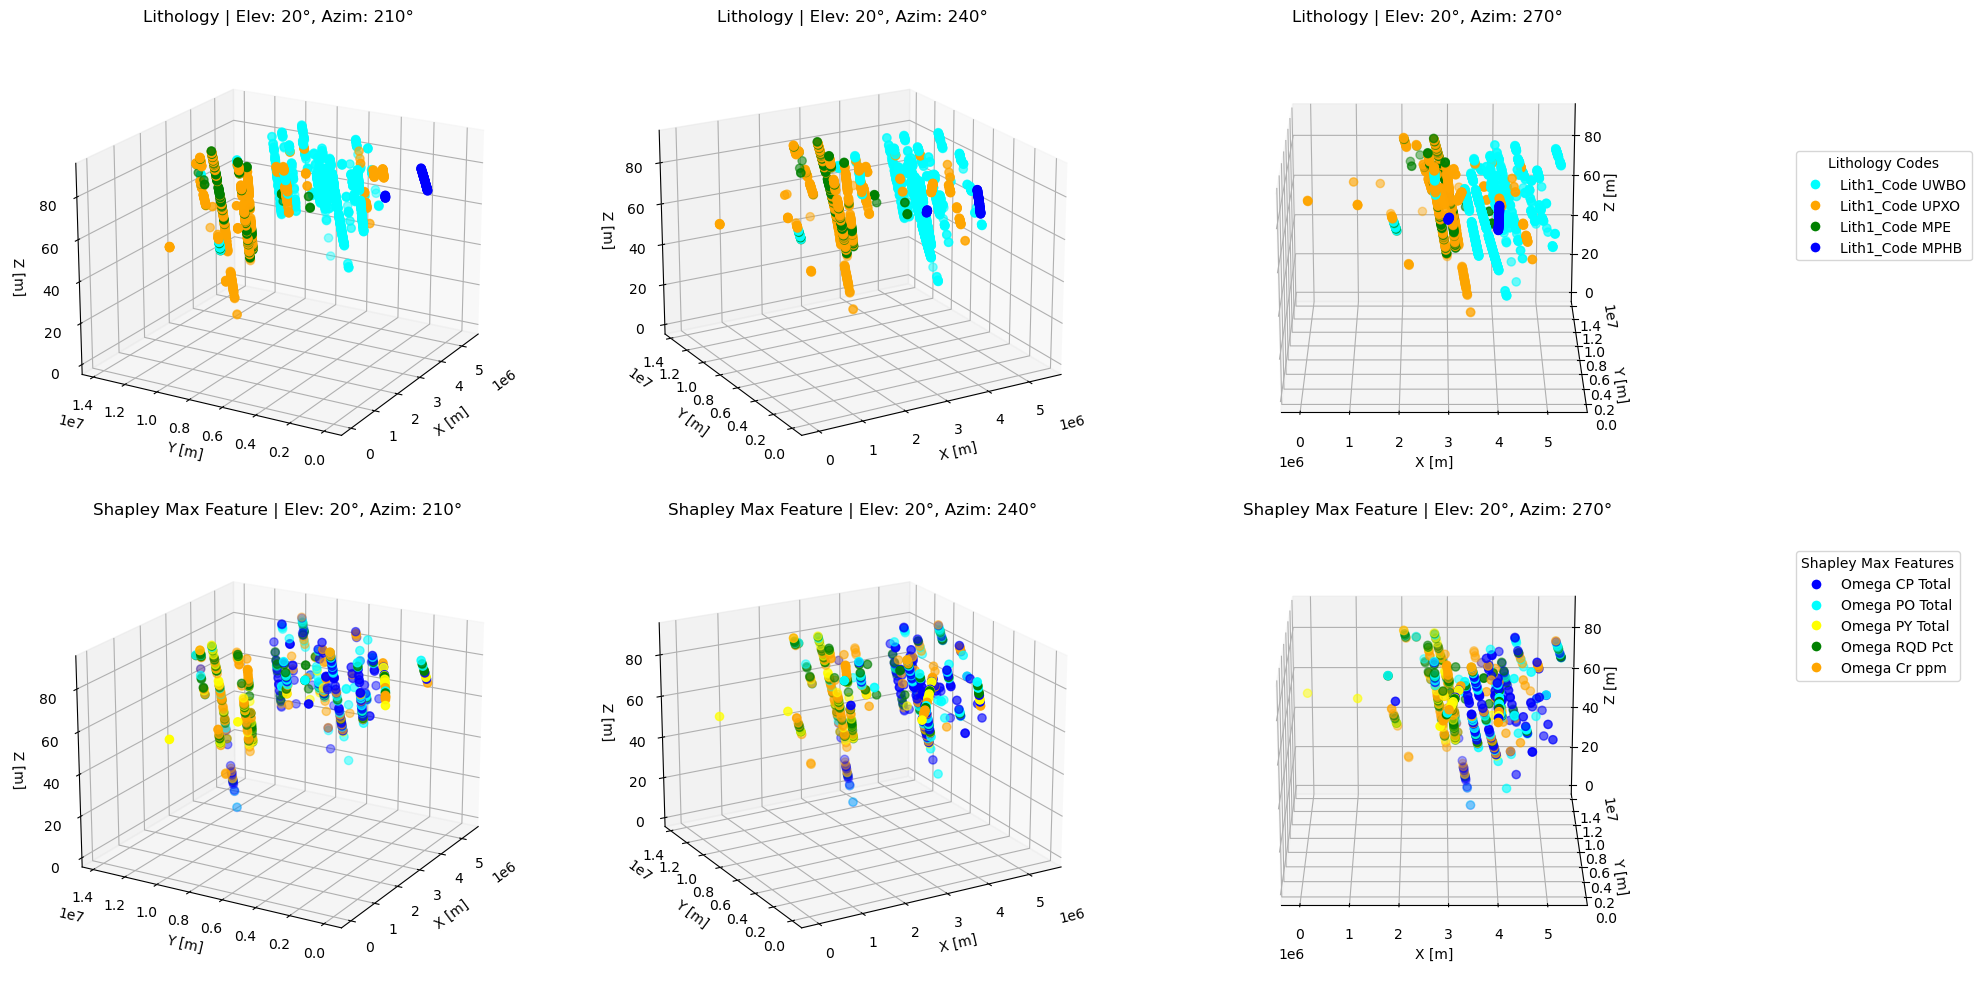

In [18]:
top_lith_codes = composite_data['Lith1_Code'].value_counts().nlargest(4).index
filtered_data = composite_data[composite_data['Lith1_Code'].isin(top_lith_codes)]
scaled_filtered_xyz = filtered_data[['X', 'Y', 'Z']].values * [multipliers['X'], multipliers['Y'], multipliers['Z']]
scaled_test_data_xyz = trainer_regular.test_data[['X', 'Y', 'Z']].values * [multipliers['X'], multipliers['Y'], multipliers['Z']]

# Extract Lith1_Code colors and create colormap for lithology
top_lith_codes = composite_data['Lith1_Code'].value_counts().nlargest(4).index
colors_lith = ['cyan', 'orange', 'green', 'blue']
cmap_lith = ListedColormap(colors_lith[:4])

# Mapping each Lith1_Code to a color index
lith_codes = filtered_data['Lith1_Code'].values
lith_code_to_color = {code: i for i, code in enumerate(top_lith_codes)}
color_indices_lith = np.array([lith_code_to_color[code] for code in lith_codes])

# Define Shapley colors and colormap
omega_values = np.stack([omega_CP_Total, omega_PO_Total, omega_PY_Total, omega_RQD_Pct, omega_Cr_ppm], axis=1)
max_indices_shapley = np.argmax(omega_values, axis=1)
colors_shapley = ['blue', 'cyan', 'yellow', 'green', 'orange']
cmap_shapley = ListedColormap(colors_shapley)

# Define angles for different perspectives
angles = [(20, 210), (20, 240), (20, 270)]

# Create a 2x3 plot for both Lithology and Shapley max values
fig, axs = plt.subplots(2, 3, figsize=(18, 10), subplot_kw={'projection': '3d'})

# Top row: Lithology with scaled coordinates
for i, angle in enumerate(angles):
    elev, azim = angle
    axs[0, i].view_init(elev=elev, azim=azim)
    scatter = axs[0, i].scatter(scaled_filtered_xyz[:, 0], scaled_filtered_xyz[:, 1], scaled_filtered_xyz[:, 2], 
                                c=color_indices_lith, cmap=cmap_lith, s=35)
    axs[0, i].set_xlabel('X [m]')
    axs[0, i].set_ylabel('Y [m]')
    axs[0, i].set_zlabel('Z [m]')
    axs[0, i].set_title(f'Lithology | Elev: {elev}°, Azim: {azim}°')

# Bottom row: Shapley max feature with scaled coordinates
for i, angle in enumerate(angles):
    elev, azim = angle
    axs[1, i].view_init(elev=elev, azim=azim)
    scatter = axs[1, i].scatter(scaled_test_data_xyz[:, 0], scaled_test_data_xyz[:, 1], scaled_test_data_xyz[:, 2], 
                                c=max_indices_shapley, cmap=cmap_shapley, s=35)
    axs[1, i].set_xlabel('X [m]')
    axs[1, i].set_ylabel('Y [m]')
    axs[1, i].set_zlabel('Z [m]')
    axs[1, i].set_title(f'Shapley Max Feature | Elev: {elev}°, Azim: {azim}°')

# Add legends for each row
handles_lith = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors_lith[i], markersize=8) for i in range(4)]
labels_lith = [f'Lith1_Code {code}' for code in top_lith_codes]
fig.legend(handles_lith, labels_lith, loc='upper left', title="Lithology Codes", bbox_to_anchor=(1.02, 0.85))

handles_shapley = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors_shapley[i], markersize=8) for i in range(5)]
labels_shapley = ['Omega CP Total', 'Omega PO Total', 'Omega PY Total', 'Omega RQD Pct', 'Omega Cr ppm']
fig.legend(handles_shapley, labels_shapley, loc='upper left', title="Shapley Max Features", bbox_to_anchor=(1.02, 0.45))

plt.tight_layout()
plt.show()


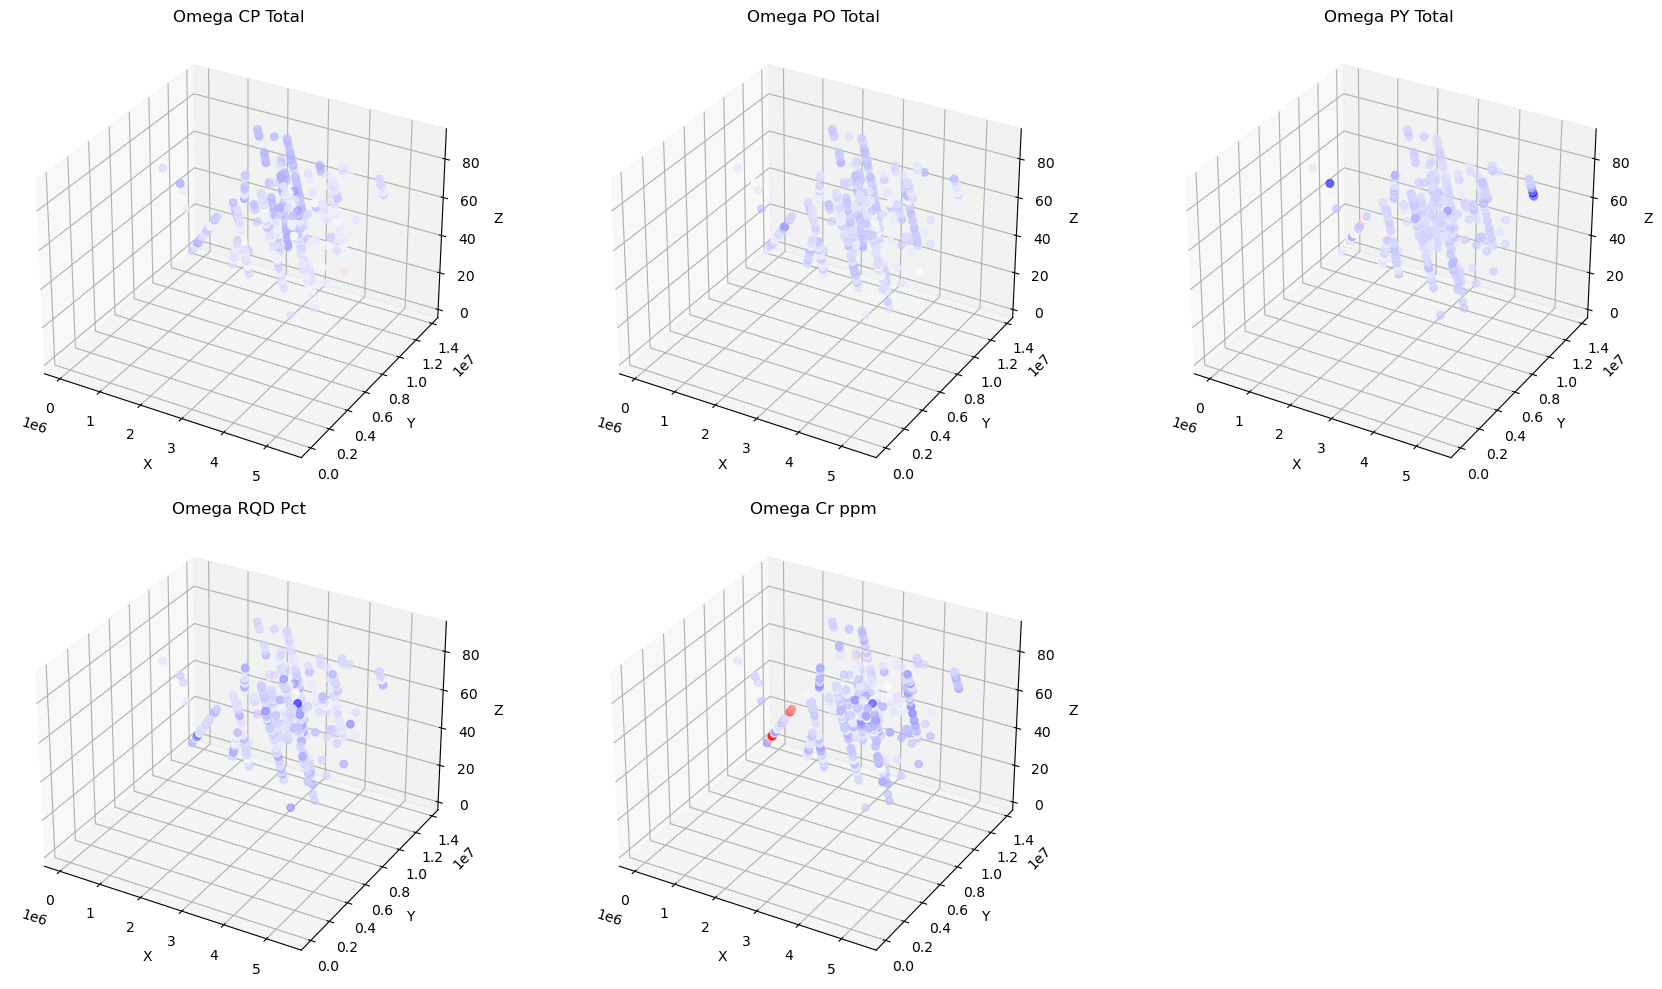

In [21]:
from matplotlib.colors import Normalize, LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D

all_omegas = np.concatenate([omega_CP_Total, omega_PO_Total, omega_PY_Total, omega_RQD_Pct, omega_Cr_ppm])
min_value = all_omegas.min()
max_value = all_omegas.max()

colors = [(1, 0, 1), (0, 1, 1)]  # Magenta to Cyan
cmap_name = 'MagentaCyan'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

fig, axs = plt.subplots(2, 3, figsize=(18, 10), subplot_kw={'projection': '3d'})

scatter1 = axs[0, 0].scatter(scaled_test_data_xyz[:, 0], scaled_test_data_xyz[:, 1], scaled_test_data_xyz[:, 2], c=omega_CP_Total, cmap='bwr', s=28, vmin=min_value, vmax=max_value)
scatter2 = axs[0, 1].scatter(scaled_test_data_xyz[:, 0], scaled_test_data_xyz[:, 1], scaled_test_data_xyz[:, 2], c=omega_PO_Total, cmap='bwr', s=28, vmin=min_value, vmax=max_value)
scatter3 = axs[0, 2].scatter(scaled_test_data_xyz[:, 0], scaled_test_data_xyz[:, 1], scaled_test_data_xyz[:, 2], c=omega_PY_Total, cmap='bwr', s=28, vmin=min_value, vmax=max_value)
scatter4 = axs[1, 0].scatter(scaled_test_data_xyz[:, 0], scaled_test_data_xyz[:, 1], scaled_test_data_xyz[:, 2], c=omega_RQD_Pct, cmap='bwr', s=28, vmin=min_value, vmax=max_value)
scatter5 = axs[1, 1].scatter(scaled_test_data_xyz[:, 0], scaled_test_data_xyz[:, 1], scaled_test_data_xyz[:, 2], c=omega_Cr_ppm, cmap='bwr', s=28, vmin=min_value, vmax=max_value)

axs[0, 0].set_title('Omega CP Total')
axs[0, 1].set_title('Omega PO Total')
axs[0, 2].set_title('Omega PY Total')
axs[1, 0].set_title('Omega RQD Pct')
axs[1, 1].set_title('Omega Cr ppm')

axs[1, 2].axis('off')

for ax in axs.flat:
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

norm = Normalize(vmin=min_value, vmax=max_value)
sm = plt.cm.ScalarMappable(cmap='bwr', norm=norm)
sm.set_array([])
#cbar = fig.colorbar(sm, ax=axs[:, :2], pad=0.05, aspect=20, extend='both')
#cbar.set_label('Omega Values')

plt.tight_layout()
plt.show()
